In [ ]:
!pip install --upgrade jax==0.5.1 jaxlib==0.5.1
!pip install jaxkan diffrax

In [ ]:
from jaxkan.KAN import KAN
import jax
import jaxlib
import jax.numpy as jnp
import numpy as np
from flax import nnx
import optax
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5, PIDController
import matplotlib.pyplot as plt
import time

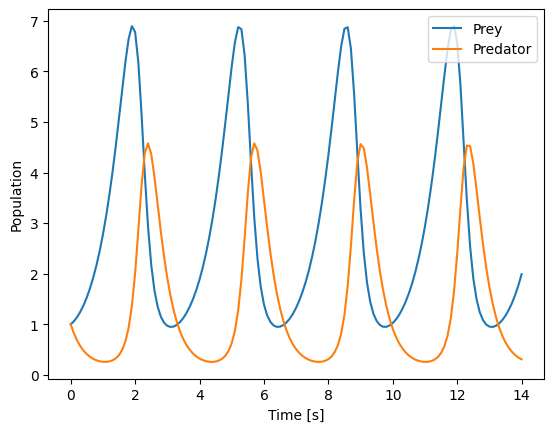

In [ ]:
# Ground Truth:

def vector_field(t, y, args):

    prey, predator = y
    α, β, γ, δ = args
    d_prey = α * prey - β * prey * predator
    d_predator = γ * prey * predator - δ * predator
    d_y = d_prey, d_predator

    return d_y

term = ODETerm(vector_field)
solver = Tsit5()
t0 = 0
t1 = 14
dt0 = 0.1
y0 = (1,1)
args = (1.5, 1, 1, 3)
stepsize_controller = PIDController(rtol = 1e-4, atol = 1e-6)
saveat = SaveAt(ts = jnp.linspace(t0, t1, 141))

sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args = args, saveat = saveat, stepsize_controller = stepsize_controller)

plt.plot(sol.ts, sol.ys[0], label = "Prey")
plt.plot(sol.ts, sol.ys[1], label = "Predator")
plt.xlabel("Time [s]")
plt.ylabel("Population")
plt.legend()
plt.show()

In [ ]:
# Dataset:

t = sol.ts
solutions = jnp.stack((sol.ys[0], sol.ys[1]), axis = 1)

t_train = t[:37]
solutions_train = solutions[:37, :]

t_test = t[36:]
solutions_test = solutions[36:, :]

In [ ]:
# Models definitions:

class dF(nnx.Module):

    def __init__(self, dy_dt):
        self.dy_dt = dy_dt
    def __call__(self, t, y, args):
        y = y[jnp.newaxis, :]
        return self.dy_dt(y)[0]

class NODE(nnx.Module):

    def __init__(self,dF):
        self.dF = dF

    def __call__(self, ts, y0):
        solution = diffeqsolve(
            ODETerm(self.dF),
            Tsit5(),
            t0 = ts[0],
            t1 = ts[-1],
            dt0 = ts[1] - ts[0],
            y0 = y0,
            saveat = SaveAt(ts = ts),
            stepsize_controller = PIDController(rtol = 1e-4, atol = 1e-6)
        )
        return solution.ys

In [ ]:
# Loss function:

def loss_fn(model, t, y0, solutions_true):
    solutions_pred = model(t, y0)
    return jnp.mean((solutions_pred - solutions_true) ** 2)

# Initial conditions:

y0_train = solutions_train[0, :]
y0_test = solutions_test[0, :]
y0 = solutions[0,:]

# Optimizer:

opt_type = optax.adam(learning_rate = 0.001)

In [ ]:
# L2 relative error:

def l2_relative_error(y_pred, y_true):
    numerator = jnp.linalg.norm(y_pred - y_true)
    denominator = jnp.linalg.norm(y_true)
    return numerator / denominator

In [ ]:
# Training step:

@nnx.jit
def train_step(model, optimizer, t_train, y0_train, solutions_train):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, y0_train, solutions_train)
    optimizer.update(grads)

    return train_loss

# Test step:

@nnx.jit
def test_step(model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions):

    train_loss, grads = nnx.value_and_grad(loss_fn)(model, t_train, y0_train, solutions_train)
    optimizer.update(grads)
    test_loss = loss_fn(model, t_test, y0_test, solutions_test)
    l2_error = l2_relative_error(model(t, y0), solutions)

    return train_loss, test_loss, l2_error

In [ ]:
num_epochs = 10000

In [ ]:
# KAN-ODE training with grid updates:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 3}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

grid_upds = {0 : 3, 500 : 5, 2000 : 10, 5000 : 15}

train_losses_gridup = jnp.zeros(num_epochs)
start_time = time.time()

for epoch in range(num_epochs):

    if epoch in grid_upds.keys():

        print(f"Epoch {epoch}: Performing grid update")

        G_new = grid_upds[epoch]
        KANODE_model.dF.dy_dt.update_grids(solutions_train, G_new)
        optimizer = nnx.Optimizer(KANODE_model, opt_type)

    train_loss = train_step(KANODE_model, optimizer, t_train, y0_train, solutions_train)
    train_losses_gridup = train_losses_gridup.at[epoch].set(train_loss)

print(f"Training time: {time.time() - start_time:.0f} seconds")

Epoch 0: Performing grid update
Epoch 500: Performing grid update
Epoch 2000: Performing grid update
Epoch 5000: Performing grid update
Training time: 216 seconds


In [ ]:
# KAN-ODE training without grid updates (G = 3):

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 3}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_G3 = jnp.zeros(num_epochs)
start_time = time.time()

for epoch in range(num_epochs):

    train_loss = train_step(KANODE_model, optimizer, t_train, y0_train, solutions_train)
    train_losses_G3 = train_losses_G3.at[epoch].set(train_loss)

print(f"Training time: {time.time() - start_time:.0f} seconds")

Training time: 120 seconds


In [ ]:
# KAN-ODE training without grid updates (G = 15):

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 15}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_G15 = jnp.zeros(num_epochs)
start_time = time.time()

for epoch in range(num_epochs):

    train_loss = train_step(KANODE_model, optimizer, t_train, y0_train, solutions_train)
    train_losses_G15 = train_losses_G15.at[epoch].set(train_loss)

print(f"Training time: {time.time() - start_time:.0f} seconds")

Training time: 350 seconds


In [ ]:
# KAN-ODE testing with grid updates:

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 3}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

grid_upds = {0 : 3, 500 : 5, 2000 : 10, 5000 : 15}

train_losses_gridup = jnp.zeros(num_epochs)
test_losses_gridup = jnp.zeros(num_epochs)
l2_errors_gridup = jnp.zeros(num_epochs)

for epoch in range(num_epochs):

    if epoch in grid_upds.keys():

        print(f"Epoch {epoch}: Performing grid update")

        G_new = grid_upds[epoch]
        KANODE_model.dF.dy_dt.update_grids(solutions_train, G_new)
        optimizer = nnx.Optimizer(KANODE_model, opt_type)

    train_loss, test_loss, l2_error = test_step(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)
    train_losses_gridup = train_losses_gridup.at[epoch].set(train_loss)
    test_losses_gridup = test_losses_gridup.at[epoch].set(test_loss)
    l2_errors_gridup = l2_errors_gridup.at[epoch].set(l2_error)

Epoch 0: Performing grid update
Epoch 500: Performing grid update
Epoch 2000: Performing grid update
Epoch 5000: Performing grid update


In [ ]:
# KAN-ODE testing without grid updates (G = 3):

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 3}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_G3 = jnp.zeros(num_epochs)
test_losses_G3 = jnp.zeros(num_epochs)
l2_errors_G3 = jnp.zeros(num_epochs)

for epoch in range(num_epochs):

    train_loss, test_loss, l2_error = test_step(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)
    train_losses_G3 = train_losses_G3.at[epoch].set(train_loss)
    test_losses_G3 = test_losses_G3.at[epoch].set(test_loss)
    l2_errors_G3 = l2_errors_G3.at[epoch].set(l2_error)

In [ ]:
# KAN-ODE testing without grid updates (G = 15):

KAN_model = KAN(
            layer_dims = [2, 10, 2],
            layer_type = 'spline',
            required_parameters = {'G': 15}
           )

dF_model = dF(KAN_model)
KANODE_model = NODE(dF_model)
optimizer = nnx.Optimizer(KANODE_model, opt_type)

train_losses_G15 = jnp.zeros(num_epochs)
test_losses_G15 = jnp.zeros(num_epochs)
l2_errors_G15 = jnp.zeros(num_epochs)

for epoch in range(num_epochs):

    train_loss, test_loss, l2_error = test_step(KANODE_model, optimizer, t_train, y0_train, solutions_train, t_test, y0_test, solutions_test, t, y0, solutions)
    train_losses_G15 = train_losses_G15.at[epoch].set(train_loss)
    test_losses_G15 = test_losses_G15.at[epoch].set(test_loss)
    l2_errors_G15 = l2_errors_G15.at[epoch].set(l2_error)

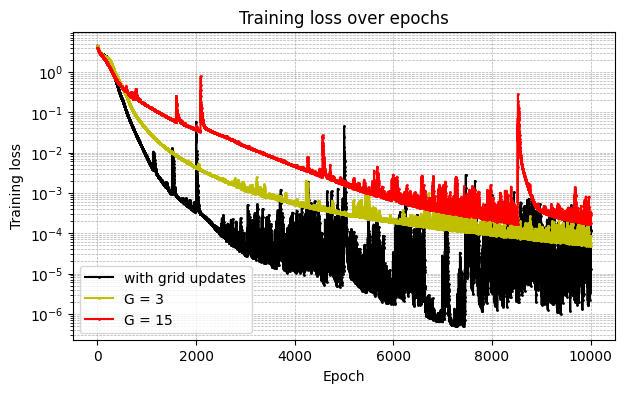

In [ ]:
# Training loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(train_losses_gridup), label = 'with grid updates', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(train_losses_G3), label = 'G = 3', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(train_losses_G15), label = 'G = 15', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [ ]:
# Final training losses:

print(f"With grid updates : {train_losses_gridup[-1]:.6f}")
print(f"G = 3 : {train_losses_G3[-1]:.6f}")
print(f"G = 15 :  {train_losses_G15[-1]:.6f}")

With grid updates : 0.000122
G = 3 : 0.000048
G = 15 :  0.000309


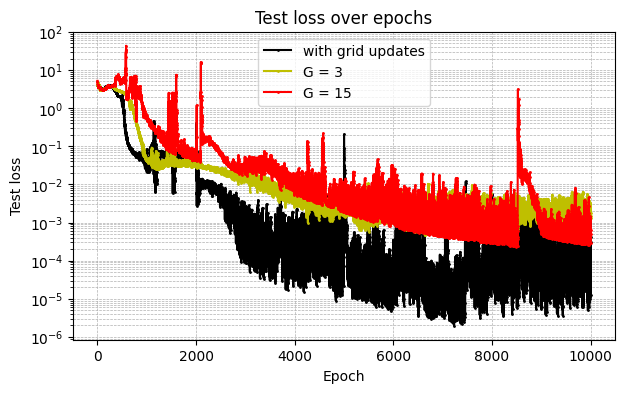

In [ ]:
# Test loss:

plt.figure(figsize = (7, 4))

plt.plot(np.array(test_losses_gridup), label = 'with grid updates', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(test_losses_G3), label = 'G = 3', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(test_losses_G15), label = 'G = 15', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('Test loss')
plt.title('Test loss over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [ ]:
# Final test losses:

print(f"With grid updates : {test_losses_gridup[-1]:.6f}")
print(f"G = 3 : {test_losses_G3[-1]:.6f}")
print(f"G = 15 :  {test_losses_G15[-1]:.6f}")

With grid updates : 0.000300
G = 3 : 0.001744
G = 15 :  0.000295


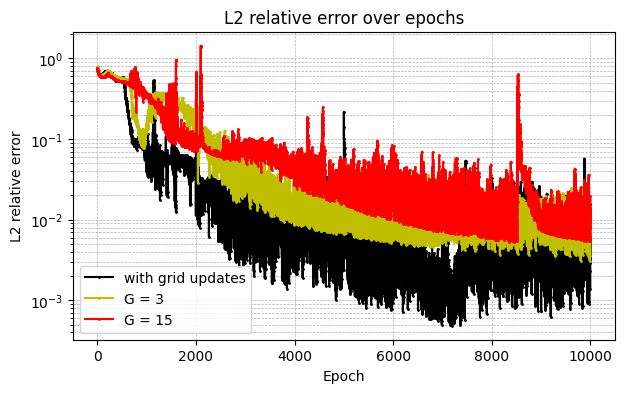

In [ ]:
# L2 relative error:

plt.figure(figsize = (7, 4))

plt.plot(np.array(l2_errors_gridup), label = 'with grid updates', marker = 'o', color = '0', markersize = 1)
plt.plot(np.array(l2_errors_G3), label = 'G = 3', marker = 'o', color = 'y', markersize = 1)
plt.plot(np.array(l2_errors_G15), label = 'G = 15', marker = 'o', color = 'r', markersize = 1)

plt.xlabel('Epoch')
plt.ylabel('L2 relative error')
plt.title('L2 relative error over epochs')
plt.yscale('log')
plt.legend()
plt.grid(True, which = 'both', linestyle = '--', linewidth = 0.5)
plt.show()

In [ ]:
# Final L2 relative errors:

print(f"With grid updates : {l2_errors_gridup[-1]:.4f}")
print(f"G = 3 : {l2_errors_G3[-1]:.4f}")
print(f"G = 15 :  {l2_errors_G15[-1]:.4f}")

With grid updates : 0.0089
G = 3 : 0.0108
G = 15 :  0.0080


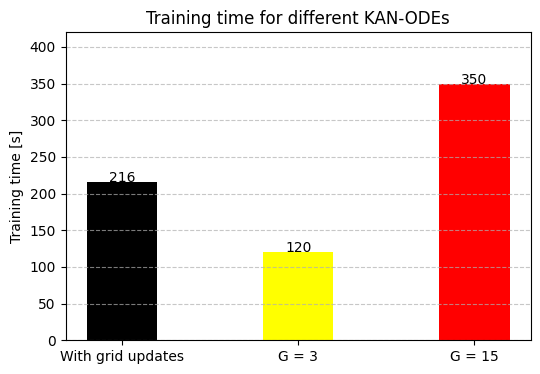

In [ ]:
# Training time:

models = ["With grid updates", "G = 3", "G = 15"]
training_times = [216, 120, 350]

plt.figure(figsize=(6, 4))
plt.bar(models, training_times, color=['black', 'yellow', 'red'], width = 0.4)

plt.ylabel("Training time [s]")
plt.title("Training time for different KAN-ODEs")
plt.ylim(0, max(training_times) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, time in enumerate(training_times):
    plt.text(i, time + 0.002, f"{time}", ha="center", fontsize=10)

plt.show()